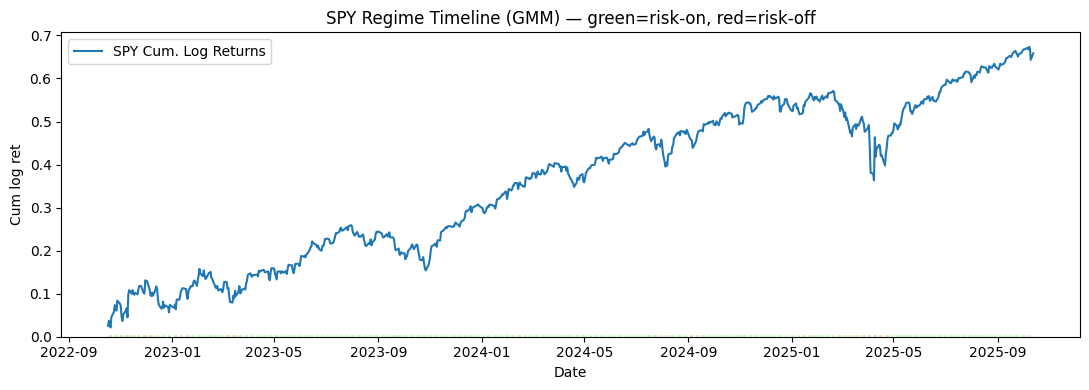

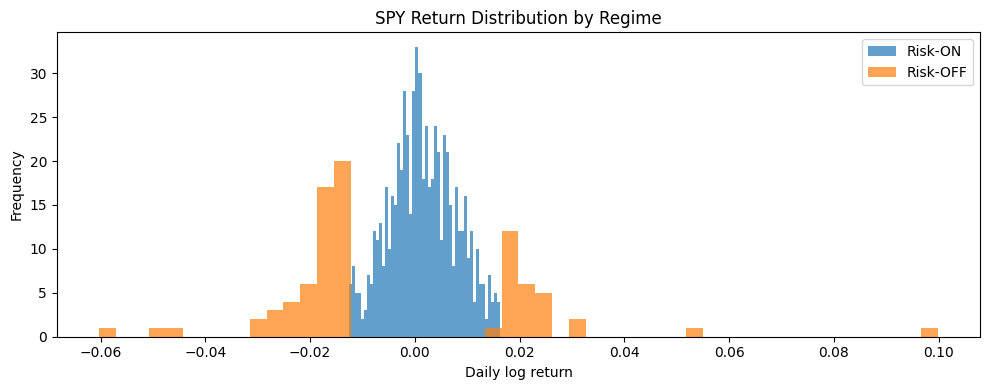

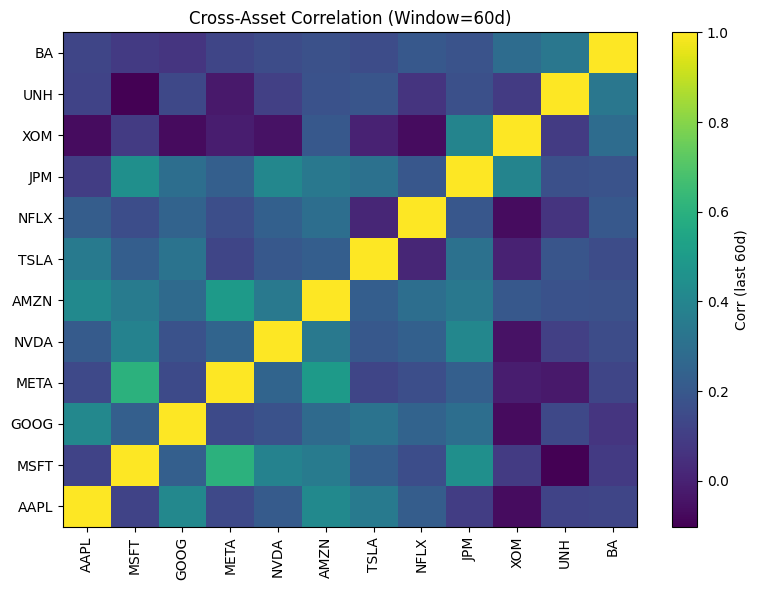

=== Regime summary (daily) ===
          N days  Mean daily ret  Vol (ann)  Sharpe (≈)
Risk-ON    654.0          0.0016     0.0989      3.9657
Risk-OFF    77.0         -0.0059     0.3732     -4.0167

=== Current clusters (Union-Find, threshold >= 0.60) ===
Cluster 1 (size 2): ['MSFT', 'META']
Cluster 2 (size 1): ['AAPL']
Cluster 3 (size 1): ['GOOG']
Cluster 4 (size 1): ['NVDA']
Cluster 5 (size 1): ['AMZN']
Cluster 6 (size 1): ['TSLA']
Cluster 7 (size 1): ['NFLX']
Cluster 8 (size 1): ['JPM']
Cluster 9 (size 1): ['XOM']
Cluster 10 (size 1): ['UNH']
Cluster 11 (size 1): ['BA']

Saved: regime_summary.csv, recent_correlation_matrix.csv


In [6]:
# Step 15 — Market Regime Detection (HMM/GMM) + Union-Find Clusters
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from datetime import datetime, timedelta

# ---------- Config ----------
BENCH = "SPY"                         # benchmark for regime detection
UNIVERSE = ["AAPL","MSFT","GOOG","META","NVDA","AMZN","TSLA","NFLX","JPM","XOM","UNH","BA"]
PERIOD = "3y"
INTERVAL = "1d"
ROLL_VOL_WIN = 20
CORR_WINDOW = 60                      # days for cross-asset clustering
CORR_THRESHOLD = 0.6                  # union edge threshold

# ---------- Data ----------
prices = yf.download([BENCH] + UNIVERSE, period=PERIOD, interval=INTERVAL,
                     auto_adjust=True, progress=False)["Close"]
if isinstance(prices, pd.Series):
    prices = prices.to_frame()
prices = prices.dropna(how="all")
returns = np.log(prices / prices.shift(1)).dropna()

bench_ret = returns[BENCH].copy()
bench_vol = bench_ret.rolling(ROLL_VOL_WIN).std() * np.sqrt(252)

# ---------- Regime model: HMM (if available) else GMM fallback ----------
def fit_regimes(series):
    X = series.values.reshape(-1, 1)

    # Try HMM
    model_name = None
    try:
        from hmmlearn.hmm import GaussianHMM
        hmm = GaussianHMM(n_components=2, covariance_type="full", n_iter=200, random_state=42)
        hmm.fit(X)
        states = hmm.predict(X)
        means = np.array([hmm.means_[i,0] for i in range(2)])
        model_name = "HMM"
    except Exception:
        # Fallback: GMM on returns only (no dynamics)
        from sklearn.mixture import GaussianMixture
        gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42, max_iter=500)
        gmm.fit(X)
        states = gmm.predict(X)
        means = np.array([gmm.means_[i,0] for i in range(2)])
        model_name = "GMM"

    # Convention: state 1 = higher-vol / lower-mean (risk-off), state 0 = risk-on
    # We’ll rank by mean; if needed you can also rank by realized vol per state
    order = np.argsort(means)  # lower-mean first
    remap = np.zeros_like(states)
    remap[states == order[0]] = 1  # risk-off
    remap[states == order[1]] = 0  # risk-on
    return remap, model_name

states, model_name = fit_regimes(bench_ret)
state_series = pd.Series(states, index=bench_ret.index, name="state")

# ---------- Regime summaries ----------
def regime_summary(ret, vol, states):
    df = pd.DataFrame({"ret": ret, "vol": vol, "state": states}).dropna()
    out = {}
    for s, label in [(0,"Risk-ON"), (1,"Risk-OFF")]:
        sub = df[df["state"]==s]
        out[label] = {
            "N days": len(sub),
            "Mean daily ret": sub["ret"].mean(),
            "Vol (ann)": sub["ret"].std()*np.sqrt(252),
            "Sharpe (≈)": (sub["ret"].mean()/sub["ret"].std())*np.sqrt(252) if sub["ret"].std()>0 else np.nan
        }
    return pd.DataFrame(out).T

summary = regime_summary(bench_ret, bench_vol, states)

# ---------- Union-Find for cross-asset correlation clusters ----------
class UnionFind:
    def __init__(self, items):
        self.parent = {x: x for x in items}
        self.rank = {x: 0 for x in items}
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def current_clusters(ret_df, window=60, threshold=0.6):
    recent = ret_df.tail(window)
    C = recent.corr().fillna(0.0)
    tickers = list(C.columns)
    uf = UnionFind(tickers)
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            if C.iloc[i,j] >= threshold:
                uf.union(tickers[i], tickers[j])
    # group
    groups = {}
    for t in tickers:
        r = uf.find(t)
        groups.setdefault(r, []).append(t)
    clusters = list(groups.values())
    clusters = sorted(clusters, key=lambda g: -len(g))
    return C, clusters

corr_mat, clusters = current_clusters(returns[UNIVERSE], CORR_WINDOW, CORR_THRESHOLD)

# ---------- Plots ----------
# 1) Regime timeline
plt.figure(figsize=(11,4))
color_map = np.where(state_series.values==1, "#ffcccc", "#ccffcc")  # red-ish risk-off, green-ish risk-on
plt.bar(state_series.index, height=0.004, width=1.0, color=color_map, align="center")
plt.plot(bench_ret.index, bench_ret.cumsum(), linewidth=1.5, label=f"{BENCH} Cum. Log Returns")
plt.title(f"{BENCH} Regime Timeline ({model_name}) — green=risk-on, red=risk-off")
plt.xlabel("Date"); plt.ylabel("Cum log ret")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Return histograms by regime
plt.figure(figsize=(10,4))
bins = 50
plt.hist(bench_ret[state_series==0], bins=bins, alpha=0.7, label="Risk-ON")
plt.hist(bench_ret[state_series==1], bins=bins, alpha=0.7, label="Risk-OFF")
plt.title(f"{BENCH} Return Distribution by Regime")
plt.xlabel("Daily log return"); plt.ylabel("Frequency"); plt.legend(); plt.tight_layout(); plt.show()

# 3) Correlation heatmap (recent window)
plt.figure(figsize=(8,6))
im = plt.imshow(corr_mat.values, origin="lower", aspect="auto")
plt.xticks(ticks=range(len(UNIVERSE)), labels=UNIVERSE, rotation=90)
plt.yticks(ticks=range(len(UNIVERSE)), labels=UNIVERSE)
plt.colorbar(im, label="Corr (last {}d)".format(CORR_WINDOW))
plt.title(f"Cross-Asset Correlation (Window={CORR_WINDOW}d)")
plt.tight_layout(); plt.show()

# ---------- Printed outputs ----------
print("=== Regime summary (daily) ===")
print(summary.round(4))
print("\n=== Current clusters (Union-Find, threshold >= {:.2f}) ===".format(CORR_THRESHOLD))
for i, g in enumerate(clusters, 1):
    print(f"Cluster {i} (size {len(g)}): {g}")

# Save artifacts
summary.to_csv(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-15\regime_summary.csv")
corr_mat.to_csv(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-15\recent_correlation_matrix.csv")
print("\nSaved: regime_summary.csv, recent_correlation_matrix.csv")
